This is a simple analysis of baseball data sets. I focused on some general questions of teams and players rather than digging into very specific ones. What's more, if you know better formulas to calculate players' performance level, feel free to contact me.

In [3]:
#Importing all the necessary libraries required for this analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [ ]:
#Reading the data from the CSV files
player = pd.read_csv("D:/Users/vin/Desktop/FinalProject-Python/the-history-of-baseball/player.csv")
salary = pd.read_csv("D:/Users/vin/Desktop/FinalProject-Python/the-history-of-baseball/salary.csv")
team =  pd.read_csv("D:/Users/vin/Desktop/FinalProject-Python/the-history-of-baseball/team.csv")
fielding = pd.read_csv("D:/Users/vin/Desktop/FinalProject-Python/the-history-of-baseball/fielding.csv")

In [42]:
import warnings
warnings.filterwarnings('ignore')
data = salary.groupby(["year","league_id"]).mean().unstack().copy(deep = True)
plt.xlabel("Year")
plt.ylabel("Salary")
plt.title("Baseball player salary over years")

#Here we focus on getting the salary between the leagues and year.


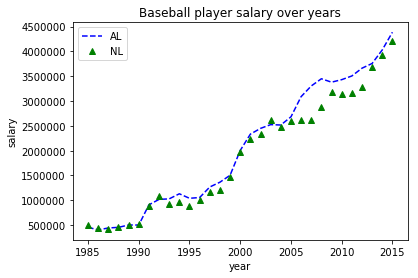

In [8]:
plt.show()

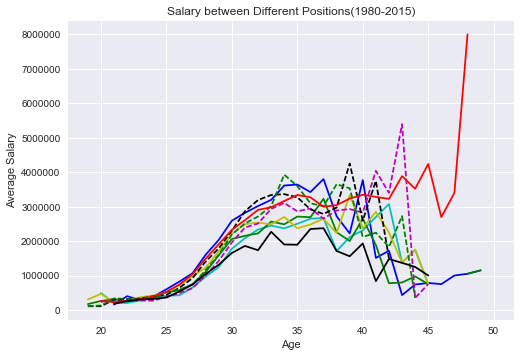

In [47]:
#Here we are finding out the salaries between different positions and age
warnings.filterwarnings('ignore')
player_position = pd.merge(salary, fielding, on = ["player_id","year"])[["year", "player_id", "salary", "pos"]]
player_position = pd.merge(player_position, player, on = ["player_id"], how = "left")[["year", "player_id","salary", "pos", "birth_year"]]
player_position["age"] = player_position["year"] - player_position["birth_year"] 
player_position = player_position[player_position.year >= 1980]
data = player_position.groupby(["age", "pos"]).mean()["salary"].unstack()
plt.plot(data["1B"], 'b-', data["2B"], 'c-', data["3B"], 'g-', data["SS"], 'y-',data['LF'], 'm--', data['CF'], 'k--', data['RF'], 'g--', data['P'],'r-', data['C'],'k-')
_ = plt.xlabel("Age")
_ = plt.ylabel("Average Salary")
_ = plt.title("Salary between Different Positions(1980-2015)")
plt.show()

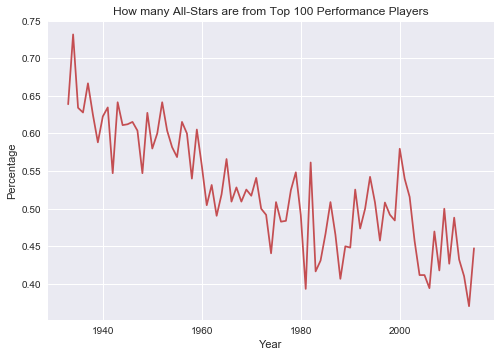

In [49]:
#Here we trying to find out if the best perfomers are selected for all-star game. We can combine 'fielding' and 'post fielding' from the year 1933 and do the analysis
all_star = pd.read_csv("D:/Users/vin/Desktop/FinalProject-Python/the-history-of-baseball/all_star.csv")[["player_id","year"]]
fielding = pd.read_csv("D:/Users/vin/Desktop/FinalProject-Python/the-history-of-baseball/fielding.csv")
fielding_postseason = pd.read_csv("D:/Users/vin/Desktop/FinalProject-Python/the-history-of-baseball/fielding_postseason.csv")
fielding = fielding[fielding["year"] >= 1933]
fielding_postseason = fielding_postseason[fielding_postseason["year"] >= 1933]
all_fielding = pd.concat([fielding, fielding_postseason], axis = 0)
all_fielding = all_fielding.groupby(["year","player_id"]).sum()[["g", "gs", "inn_outs", "po","a","e","dp","pb"]]
all_fielding = all_fielding.fillna(0)

# calculating fielding percentage
# po: Putouts / Pickoff ; a: Assist ; e: Error ; dp: Double Play; pb: Passed Balls
all_fielding["FP"] = (all_fielding["po"] + all_fielding["a"])/(all_fielding["po"] + all_fielding["a"] + all_fielding["e"])

# we don't consider those who participated less than mean_game
mean_game = all_fielding["g"].mean()
all_fielding = all_fielding[all_fielding["g"] >= mean_game]

# combine batting and batting_postseason
# ab: At Bats; bb: walk-to-strikeout ; double;  triple ; r : runs ; rbi :Run batted in　；
# h : hits ; hr : home run ; sb: Stolen bases; tb = 2*double + 3*triple + 4*home run
# g_idp : 	Double play ; cs : Caught Stealing

batting = pd.read_csv("D:/Users/vin/Desktop/FinalProject-Python/the-history-of-baseball//batting.csv")
batting_postseason = pd.read_csv("D:/Users/vin/Desktop/FinalProject-Python/the-history-of-baseball//batting_postseason.csv")
batting = batting[batting["year"] >= 1933]
batting_postseason = batting_postseason[batting_postseason["year"] >= 1933]
all_batting = pd.concat([batting, batting_postseason], axis = 0)
all_batting = all_batting.groupby(["year","player_id"]).sum()[["g","h", "double", "triple", "hr", "sb", "bb","ab","g_idp","cs"]]
all_batting = all_batting.fillna(0)

# Total Average = (h + double + 2*triple + 4*hr + sb + bb)/(ab - h + g_idp + cs)
all_batting["TA"] = (all_batting["h"] + all_batting["double"] + 2*all_batting["triple"] + 4*all_batting["hr"] + all_batting["sb"]+all_batting["bb"])/(all_batting["ab"]- all_batting["h"]+all_batting["g_idp"]+all_batting["cs"])
all_batting = all_batting[all_batting["g"] >= mean_game]

# combine pitching and pitching_postseason
pitching = pd.read_csv("D:/Users/vin/Desktop/FinalProject-Python/the-history-of-baseball/pitching.csv")
pitching_postseason = pd.read_csv("D:/Users/vin/Desktop/FinalProject-Python/the-history-of-baseball/pitching_postseason.csv")
pitching = pitching[pitching['year'] >= 1993]
pitching_postseason = pitching_postseason[pitching_postseason['year'] >= 1993]
all_pitching = pd.concat([pitching, pitching_postseason], axis = 0)
all_pitching.groupby(["year","player_id"])

# combine fielding percentage and batting average to determine the performance of a player
data1 = all_fielding["FP"]
data2 = all_batting["TA"]
data1 = data1.reset_index(level = ['year','player_id'])
data2 = data2.reset_index(level = ['year','player_id'])
data = pd.merge(data1, data2, on =['year','player_id'], how = 'inner')
data["Score"] = data['FP'] + data['TA']

year_range = list(range(1933, 2016))
percentage = pd.Series()
i = 0
for year in year_range:
    stars = all_star[all_star['year'] == year]
    star_count = len(stars.index)
    df = data[data['year'] == year]
    df = df.fillna(0)
    df = df[["year","player_id", "Score"]]
    df["rank"] = df['Score'].rank(ascending = False)
    df = df[np.isfinite(df['Score'])]
    df = df[df['rank'] <= 100]
    hs = set()
    count = 0
    for name in df["player_id"]:
        hs.add(name)
    for name in stars["player_id"]:
        if name in hs:
            count = count + 1
    percentage.set_value(i, count/star_count)
    i = i+1

plt.plot(year_range, percentage, color = sns.color_palette()[2])
plt.xlabel("Year")
plt.ylabel("Percentage")
plt.title("How many All-Stars are from Top 100 Performance Players")
plt.show()

# There are several possible reasons for this situation, the performance formula is not scientific, because of Internet vote, all-star game players are selected for their fame rather than performance.